### Installation of packages

In [1]:
pip install tensorflow

You should consider upgrading via the '/home/studio-lab-user/.conda/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Unzip the compressed folder consists of the train and test data of 7 classes

In [2]:
!unzip face_emotion.zip

Archive:  face_emotion.zip
   creating: face_emotion/train/
   creating: face_emotion/train/angry/
 extracting: face_emotion/train/angry/0.jpg  
 extracting: face_emotion/train/angry/1.jpg  
 extracting: face_emotion/train/angry/10.jpg  
 extracting: face_emotion/train/angry/10002.jpg  
 extracting: face_emotion/train/angry/10016.jpg  
 extracting: face_emotion/train/angry/10037.jpg  
 extracting: face_emotion/train/angry/10038.jpg  
 extracting: face_emotion/train/angry/10057.jpg  
 extracting: face_emotion/train/angry/10063.jpg  
 extracting: face_emotion/train/angry/10069.jpg  
 extracting: face_emotion/train/angry/10100.jpg  
 extracting: face_emotion/train/angry/10105.jpg  
 extracting: face_emotion/train/angry/10115.jpg  
 extracting: face_emotion/train/angry/10122.jpg  
 extracting: face_emotion/train/angry/10142.jpg  
 extracting: face_emotion/train/angry/1015.jpg  
 extracting: face_emotion/train/angry/10154.jpg  
 extracting: face_emotion/train/angry/10155.jpg  
 extracting: 

### Importing Required Packages

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
import glob

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import math

## Data Preparation

### Path of the directory is assigned to `face_dir`. Each image should be of size 48 * 48 

In [4]:
image_size = 48

face_dir = "face_emotion/"

### Assigning the path of `train` and `test` subfolders to `train_dir` and `test_dir`

In [5]:
train_dir = os.path.join(face_dir, "train")
test_dir = os.path.join(face_dir, "validation")

### Number of classes in train and validation datasets

In [6]:
print(f'No of classes : {len(os.listdir(train_dir))}')
print(f'No of Classes : {len(os.listdir(test_dir))}')   

No of classes : 7
No of Classes : 7


### Count of images of each emotion in Training dataset

In [7]:
emo_list =[]
train_size = 0
expressions = glob.glob('face_emotion/train')
for expression in expressions:
    emo_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
for emotion in emo_list:
    train_size += int(len(os.listdir(emotion)))
    print(f'Image of {emotion} : {len(os.listdir(emotion))}')
print(train_size)
    

Image of face_emotion/train/angry : 3993
Image of face_emotion/train/disgust : 436
Image of face_emotion/train/fear : 4103
Image of face_emotion/train/happy : 7164
Image of face_emotion/train/neutral : 4982
Image of face_emotion/train/sad : 4938
Image of face_emotion/train/surprise : 3205
28821


### Count of images of each emotion in validation dataset


In [8]:
emo_test_list =[]
test_size = 0
expressions = glob.glob('face_emotion/validation')
for expression in expressions:
    emo_test_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
for emotion in emo_test_list:
    test_size += int(len(os.listdir(emotion)))
    print(f'Image of {emotion} : {len(os.listdir(emotion))}')
print(test_size)

Image of face_emotion/validation/angry : 960
Image of face_emotion/validation/disgust : 111
Image of face_emotion/validation/fear : 1018
Image of face_emotion/validation/happy : 1825
Image of face_emotion/validation/neutral : 1216
Image of face_emotion/validation/sad : 1139
Image of face_emotion/validation/surprise : 797
7066


### Plotting the images from the dataset Randomly

In [22]:
import random
def plot_images(source_path):
    images_list =[]
    expressions = glob.glob(source_path + '/*')
    for expression in expressions:
        images_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
    random.shuffle(images_list)
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 12))
    for i in range(1,20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(images_list[i], target_size=(image_size, image_size))
        plt.imshow(img)
    plt.show()

### calling the plot_images function by passing `train_dir` as path

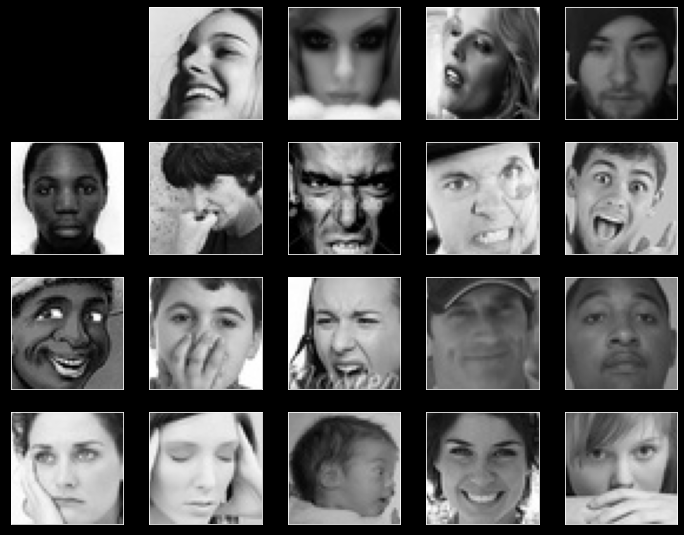

In [23]:
plot_images(train_dir)


### calling the plot_images function by passing `test_dir` as path

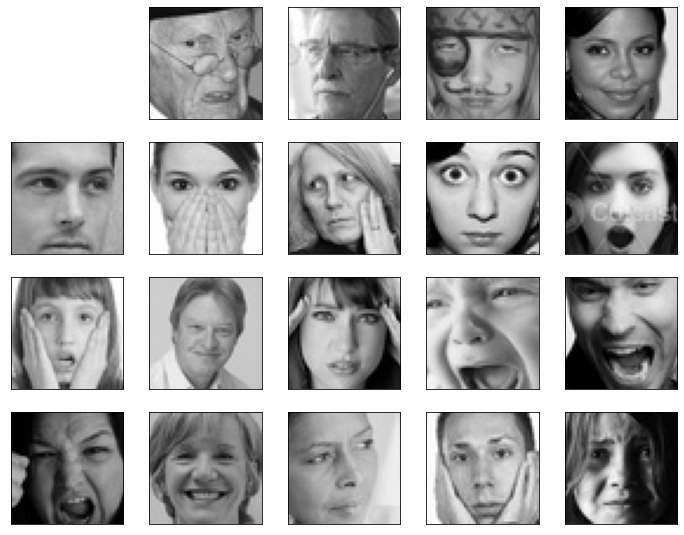

In [11]:
plot_images(test_dir)

### Function for displaying the emotion according to the expression passing as argument

In [12]:
def plot_image_acc_emotion(face_exp):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(face_dir+"/train/"+face_exp+"/"+
                      os.listdir(face_dir + "/train/" + face_exp)[i], target_size=(image_size, image_size))
        plt.imshow(img)   
    plt.show()

### PLot the images based on the emotion 'happy' which is of highest number 

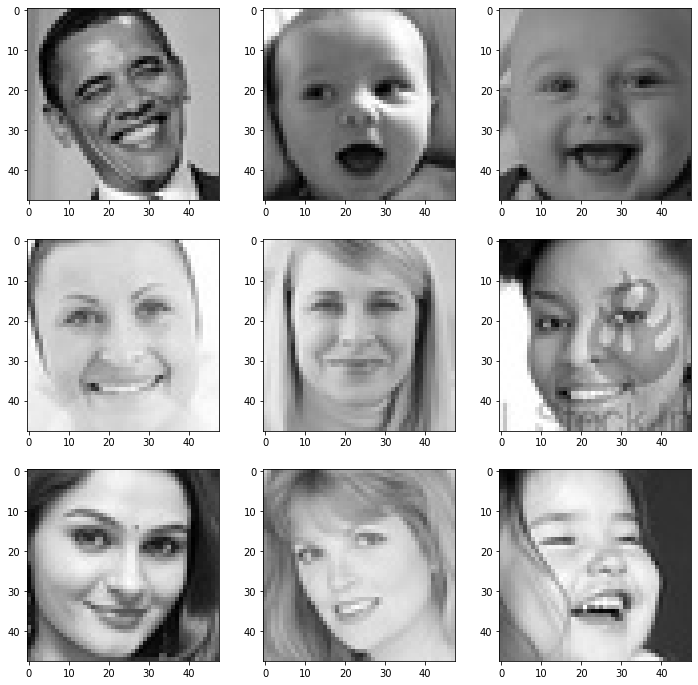

In [13]:
plot_image_acc_emotion('happy')

### PLot the images based on the emotion 'fear'

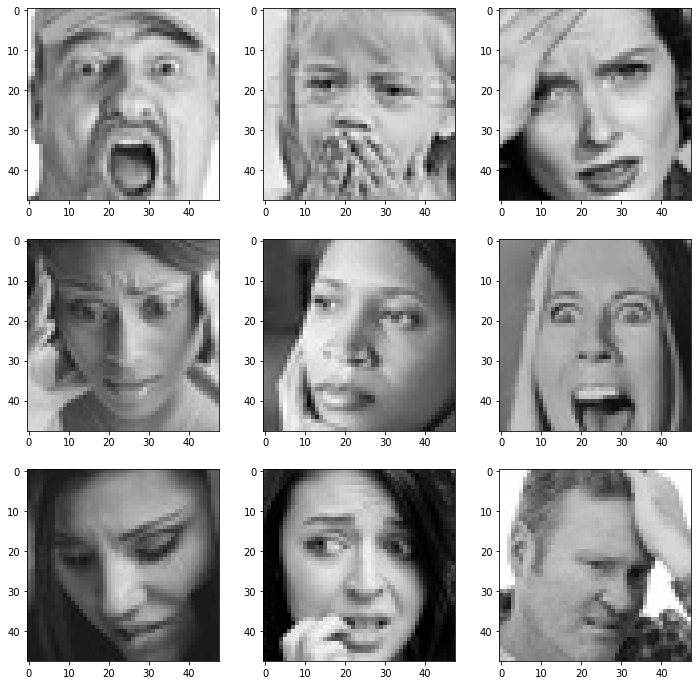

In [14]:
plot_image_acc_emotion('fear')

## Data Augmentation

### Total Images of different emotions varies, So, to balance the data, imagedatagenerator is used through which, new images will be generated according to the parameters. In training set , I split as 80:20; training:validation for testing purpose.

In [24]:
train_image_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
)

test_image_datagen = ImageDataGenerator(rescale=1./255)

### `flow_from_directory` used to read the images from the train directory path mentioned as parameter abd create two subdirectories 'training', 'validation' and stores into two different variables.

In [25]:
train_image_generator = train_image_datagen.flow_from_directory(train_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale",
        subset = 'training',                                                    
        shuffle = True)

valid_image_generator = train_image_datagen.flow_from_directory(train_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale",
        subset = 'validation' ,                                                       
        shuffle = False)


Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.


### `flow_from_directory` used to read the images from the test directory path mentioned as parameter.

In [26]:
test_image_generator = test_image_datagen.flow_from_directory(test_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale")

Found 7066 images belonging to 7 classes.
